In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse
import heartpy as hp
import os
import pickle

In [2]:
def plt_performance(history, path='./', filename=''):
    epoch = list(range(0,len(history.history['loss'])))
    
    fig, (his_accuracy, his_loss) = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
    his_loss.plot(epoch, history.history['loss'], label='Training loss')
    his_loss.plot(epoch, history.history['val_loss'], label='Validation loss')
    his_loss.set_xlabel("Epochs", fontsize=14)
    his_loss.set_ylabel("Loss", fontsize=14)
    his_loss.set_title("Loss", fontsize=14)
    his_loss.legend(loc='best')
    
    his_accuracy.plot(epoch, history.history['acc'], label='Training accuracy')
    his_accuracy.plot(epoch, history.history['val_acc'], label='Validation accuracy')
    his_accuracy.set_xlabel("Epochs", fontsize=14)
    his_accuracy.set_ylabel("Accuracy", fontsize=14)
    his_accuracy.set_title("Accuracy", fontsize=14)
    his_accuracy.legend(loc='best')
    
    fig.tight_layout()
    if filename == '':
        plt.savefig(f'{path}/performance.png', bbox_inches='tight')
    else:
        plt.savefig(f'{path}/{filename}.png', bbox_inches='tight')
    

def preprocessing(ppg_data, view = False, participant = ''):
    # moving average function
    m_avg = lambda t, x, w : (np.asarray([t[i] for i in range(w, len(x) - w)]),
                          np.convolve(x, np.ones((2*w + 1, )) / (2*w + 1),
                                      mode = 'valid'))

    fs = len(ppg_data)/(60)  # sample rate

    # moving average
    w_size = int(fs*.5)  # width of moving window
    times = list(range(0,len(ppg_data)))
    mt, ms = m_avg(times, ppg_data, w_size)

    sign = (ppg_data[w_size:-w_size]-ms)

    analytical_signal = np.abs(signal.hilbert(sign))

    fs = len(sign) / (max(mt) - min(mt))
    w_size = int(fs)
    mt_new, mov_avg = m_avg(mt, analytical_signal, w_size)

    signal_pure = sign[w_size : -w_size] / mov_avg
    
    if view:
        plt.ioff()
        
        fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8), sharex=True)
        ax1.plot(times, ppg_data, "b-", label="Original")
        ax1.legend(loc='best')
        ax1.set_title("participants"+str(participant)+" Raw", fontsize=14)#, fontweight="bold")

        ax2.plot(mt, sign, 'r-', label="Pure signal")
        ax2.plot(mt_new, mov_avg, 'b-', label='Modulation', alpha=.5)
        ax2.legend(loc='best')
        ax2.set_title("Raw -> filtered", fontsize=14)#, fontweight="bold")

        ax3.plot(mt_new, signal_pure, "g-", label="Demodulated")
        ax3.set_xlim(0, mt[-1])
        ax3.set_title("Raw -> filtered -> demodulated", fontsize=14)#, fontweight="bold")

        ax3.set_xlabel("Time (sec)", fontsize=14) # common axis label
        ax3.legend(loc='best')

        fig.tight_layout()
        plt.savefig(f'./plot_img/{participant}.png', bbox_inches='tight')
        
    return signal_pure

def display_raw(ppg_data):
    plt.ioff()
        
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8), sharex=True)
    ax1.plot(times, ppg_data, "b-", label="Original")
    ax1.legend(loc='best')
    ax1.set_title("participants"+str(participant)+" Raw", fontsize=14)#, fontweight="bold")

    ax3.set_xlabel("Time (sec)", fontsize=14) # common axis label
    ax3.legend(loc='best')

    fig.tight_layout()
    plt.savefig(f'./plot_img/{participant}.png', bbox_inches='tight')

In [3]:
dir_list_ = os.listdir("./data")
dir_list_.sort()
count = 0
dir_list = []
# dir_list_.pop(0)
dir_list = dir_list_

In [4]:
df_PPG = pd.DataFrame(columns=['participant','video_number','ppg','valence','arousal'])

file_num = 0
for file in dir_list:
    dat_file = f'./data/{file}'
    with open(dat_file, 'rb') as f:
        Channel_data = pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for video_num in range(40):
        dataP = data[video_num,38]
        dataP = dataP[384:]
        
        label = labels[video_num]
        if label[0] < 5:
            Valence = 0
        if label[0] >= 5:
            Valence = 1
        if label[1] < 5:
            Arousal = 0
        if label[1] >= 5:
            Arousal = 1
        instance = [(file_num, video_num, dataP, Valence, Arousal)]
        new_instance = pd.DataFrame(instance, columns=['participant','video_number','ppg','valence','arousal'])
        df_PPG = pd.concat([df_PPG, new_instance], ignore_index = True)
    
    file_num += 1

In [5]:
df_PPG.head(5)

,participant,video_number,ppg,valence,arousal
0,0,0,"[8121.617533123139, 8078.161162384611, 8065.46...",1,1
1,0,1,"[788.487211825035, 683.9966125211577, 604.8962...",1,1
2,0,2,"[-10340.018466416446, -10405.4471594385, -1049...",1,1
3,0,3,"[5761.629905022521, 5858.796396898557, 5914.94...",0,1
4,0,4,"[235.95451299435808, 46.99254135604133, -118.0...",1,0


In [6]:
df_PPG.tail(5)

,participant,video_number,ppg,valence,arousal
1275,31,35,"[-15.438773556366868, 13.779922454859843, 13.0...",0,1
1276,31,36,"[-72.23391600921241, -88.20263650304878, -70.8...",0,1
1277,31,37,"[31.275658356296844, -12.318011093610039, 21.8...",0,1
1278,31,38,"[2.7456817755301017, 6.464424904232146, -4.848...",0,1
1279,31,39,"[6.198312114656801, 19.29203792075714, -7.2391...",1,0


In [7]:
PPG_data = df_PPG['ppg']
Valence = df_PPG['valence']
Arousal = df_PPG['arousal']

preprocessed = []

count = 0
for PPG in PPG_data:
    vid_num = 19
    # if count % 40 == vid_num:
    #     participant = str(int(count / 40))+f'[{vid_num}]'
    #     preprocessed_d = preprocessing(PPG,view=True,participant=participant)
    #     preprocessed.append(preprocessed_d)
    # else:
    #     preprocessed_d = preprocessing(PPG,view=False)
    #     preprocessed.append(preprocessed_d)
    preprocessed_d = preprocessing(PPG,view=False)
    preprocessed.append(preprocessed_d)
    count += 1

In [8]:
print(len(preprocessed))

1280


In [9]:
preprocessed = preprocessed[:-40*11]
Valence = Valence[:-40*11]
Arousal = Arousal[:-40*11]

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [12]:
# window = 1280
timestep = 128
segmented = []
valence_data = []
arousal_data = []

# index = 0
# for PPG in preprocessed:
#     temp = []
#     for i in range(window, len(PPG), timestep):
#         valence_data.append(Valence[index])
#         arousal_data.append(Arousal[index])
#         segmented.append(PPG[i-window:i])
#     index = index+1
for index in range(len(preprocessed) - timestep): 
    segmented.append(preprocessed[index: index + timestep])
valence_data = Valence[timestep:]
arousal_data = Arousal[timestep:]
print(len(Arousal))

840


In [13]:
train_samples = int(len(segmented)*0.8)

train_x = segmented[:train_samples]
train_valence = valence_data[:train_samples]
train_arousal = arousal_data[:train_samples]

test_x = segmented[train_samples:]
test_valence = valence_data[train_samples:]
test_arousal = arousal_data[train_samples:]
print(len(test_x))

143


In [14]:
x_train_data = np.array(train_x).astype(np.float32)
x_test_data = np.array(test_x).astype(np.float32)
y_train_data = np.array(train_valence).astype(np.float32)
y_test_data = np.array(test_valence).astype(np.float32)
print(x_train_data.shape, y_train_data.shape, x_test_data.shape, y_test_data.shape)

# x_train_data = x_train_data.reshape((x_train_data.shape[0],x_train_data.shape[1], 1))
# x_test_data = x_test_data.reshape((x_test_data.shape[0],x_test_data.shape[1], 1))

# normalize train data
nsamples, nx, ny = x_train_data.shape
train_dataset = x_train_data.reshape((nsamples,nx*ny))
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(train_dataset)
# normalize test data
Test_nsamples, Test_nx, Test_ny = x_test_data.shape
test_dataset = x_test_data.reshape((Test_nsamples,Test_nx*Test_ny))
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_data = scaler.fit_transform(test_dataset)

X_train = x_train_data.reshape((x_train_data.shape[0],nx, ny))
X_test = x_test_data.reshape((x_test_data.shape[0],Test_nx,Test_ny))
Y_train = y_train_data.reshape((y_train_data.shape[0], 1))
Y_test = y_test_data.reshape((y_test_data.shape[0],1))

print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")
print(f"X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}")

(569, 128, 7550) (569,) (143, 128, 7550) (143,)
X_train shape : (569, 128, 7550), Y_train shape : (569, 1)
X_test shape : (143, 128, 7550), Y_test shape : (143, 1)


In [15]:
# Set Hyperparameters of the model
learning_rate = 0.001
epochs = 100
batch_size=128

In [16]:
# one GRU layers with three dense layers-> IT WORKS !
model = Sequential()
model.add(GRU(units=256,
              dropout=0.25,
              recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=X_train[0].shape))

# Dense net
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=30)]

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               5996544   
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 6,259,713
Trainable params: 6,259,713
Non-trainable params: 0
______________________________________________

In [17]:
history=model.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test,Y_test),
                  callbacks=callback_list,
                  verbose=1)

Epoch 1/100
5/5 [==============================] - 3s 565ms/step - loss: 0.7001 - acc: 0.5589 - val_loss: 0.7733 - val_acc: 0.4545
Epoch 2/100
5/5 [==============================] - 3s 538ms/step - loss: 0.4340 - acc: 0.8401 - val_loss: 1.1529 - val_acc: 0.4615
Epoch 3/100
5/5 [==============================] - 3s 550ms/step - loss: 0.2380 - acc: 0.9121 - val_loss: 1.6683 - val_acc: 0.4615
Epoch 4/100
5/5 [==============================] - 3s 634ms/step - loss: 0.1154 - acc: 0.9649 - val_loss: 2.9229 - val_acc: 0.4615
Epoch 5/100
5/5 [==============================] - 3s 662ms/step - loss: 0.0357 - acc: 0.9982 - val_loss: 2.5421 - val_acc: 0.4545
Epoch 6/100
5/5 [==============================] - 3s 620ms/step - loss: 0.0216 - acc: 0.9965 - val_loss: 2.2644 - val_acc: 0.4685
Epoch 7/100
5/5 [==============================] - 3s 621ms/step - loss: 0.0160 - acc: 0.9947 - val_loss: 2.8954 - val_acc: 0.4476
Epoch 8/100
5/5 [==============================] - 3s 585ms/step - loss: 0.0045 - a

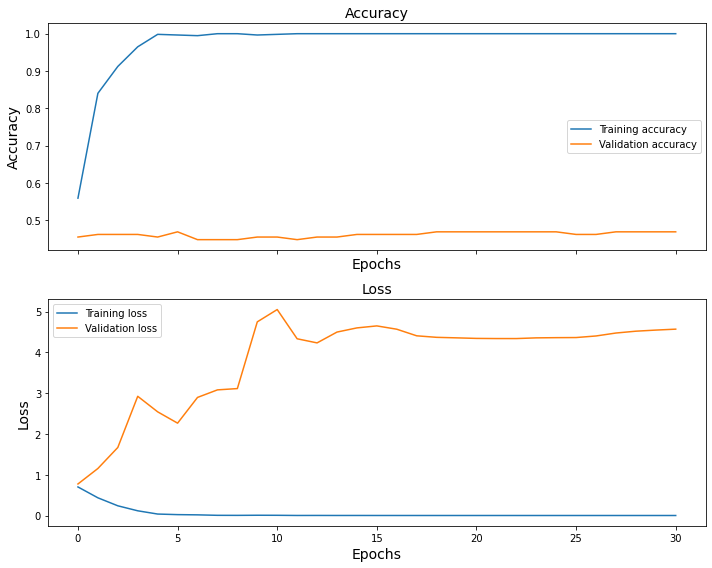

In [18]:
plt_performance(history,path='./plot_performance',filename='GRU_performance')